# Step1: Read the file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, desc
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.sql import functions as F

# Import packages
import requests
from io import StringIO
import pandas as pd
import faiss
import os
import time

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## Read to CSV and drop the first collumn since it's meanless

In [2]:
df_pd = pd.read_csv("credit_card_transactions.csv").drop(columns=['Unnamed: 0'], axis=1)

In [3]:
df_pd.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


# Step2: Preprocess data

In [4]:
def preprocess(df):
    encoder= LabelEncoder()
    scaler= RobustScaler()

    for col in df.columns:
        if df[col].dtype=='O':
            df[col]= encoder.fit_transform(df[col])
    df= scaler.fit_transform(df)

    del(encoder)
    del(scaler)

In [5]:
df_pd.drop(inplace=True, axis=1, columns=['merch_zipcode', 'cc_num'])
preprocess(df_pd)

In [6]:
df_train, df_test= train_test_split(df_pd, test_size=0.2, random_state=42, shuffle=True)
preprocess(df_train)
preprocess(df_test)
print(f'train size: {df_train.shape}, test size: {df_test.shape}')

train size: (1037340, 21), test size: (259335, 21)


# Step3: Store to faiss vector database

In [7]:
# Convert the Pandas DataFrames to NumPy arrays and ensure they are float32 type
train_data = df_train.values.astype('float32')
test_data = df_test.values.astype('float32')

# Step 1: Define the dimension (number of columns) for FAISS
dimension_train = train_data.shape[1]
dimension_test = test_data.shape[1]

# Ensure the dimensions match for train and test
assert dimension_train == dimension_test, "Train and test dimensions must match."

# Step 2: Create FAISS indices for train and test data
index_train = faiss.IndexFlatL2(dimension_train)  # L2 distance metric for the train set
index_test = faiss.IndexFlatL2(dimension_test)    # L2 distance metric for the test set

# Step 3: Add the vectors to the FAISS index
index_train.add(train_data)
index_test.add(test_data)

# Step 4: Optional - Save the FAISS indices to files for later use
faiss.write_index(index_train, 'faiss_train_data.index')
faiss.write_index(index_test, 'faiss_test_data.index')

# Print the number of vectors in each index
print(f"Number of vectors in the training index: {index_train.ntotal}")
print(f"Number of vectors in the test index: {index_test.ntotal}")

Number of vectors in the training index: 1037340
Number of vectors in the test index: 259335


## check whether vector database created successfully

In [8]:
# List all files in the current directory
files_in_directory = os.listdir()

# Filter files that are FAISS index files (typically have `.index` extension)
faiss_indexes = [f for f in files_in_directory if f.endswith('.index')]

print("Existing FAISS index files:", faiss_indexes)

Existing FAISS index files: ['faiss_train_data.index', 'faiss_test_data.index']


# Step4: Data exploration

## Read the train test database back to panda df for data visualization

In [9]:
# Function to read FAISS index and convert it back to a Pandas DataFrame
def read_faiss_to_dataframe(index_file, column_names):
    # Step 1: Load the FAISS index
    index = faiss.read_index(index_file)
    
    # Step 2: Retrieve the number of vectors and the dimension of the data
    num_vectors = index.ntotal  # The total number of vectors stored
    dimension = index.d         # The dimension of each vector (number of columns in the original dataframe)
    
    # Step 3: Initialize a NumPy array to hold the vectors
    retrieved_vectors = np.zeros((num_vectors, dimension), dtype='float32')
    
    # Step 4: Use FAISS to reconstruct the vectors
    index.reconstruct_n(0, num_vectors, retrieved_vectors)
    
    # Step 5: Convert the NumPy array back to a Pandas DataFrame
    df_reconstructed = pd.DataFrame(retrieved_vectors, columns=column_names)
    
    return df_reconstructed

In [10]:
# Assuming the original DataFrame had column names before preprocessing
column_names = list(df_pd.columns)  # Use the original column names or modify as needed

# Step 6: Read both the training and test FAISS indices into Pandas DataFrames
df_train = read_faiss_to_dataframe('faiss_train_data.index', column_names)
df_test = read_faiss_to_dataframe('faiss_test_data.index', column_names)


In [11]:
print("df_train DataFrame:")
df_train.head()

df_train DataFrame:


,trans_date_trans_time,merchant,category,amt,first,last,gender,street,city,state,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,325426.0,340.0,13.0,6.510000,239.0,234.0,0.0,677.0,270.0,18.0,...,30.657600,-91.626404,1178.0,99.0,157.0,1234400.0,1.338994e+09,31.189016,-91.426376,0.0
1,785703.0,476.0,0.0,20.170000,298.0,217.0,0.0,717.0,171.0,47.0,...,48.340000,-122.345596,85.0,390.0,704.0,1075528.0,1.354563e+09,47.373665,-122.739098,0.0
2,1239157.0,571.0,5.0,35.849998,98.0,408.0,0.0,683.0,406.0,43.0,...,32.383598,-94.865303,24536.0,300.0,688.0,1284208.0,1.370693e+09,31.989882,-95.371117,0.0
3,406299.0,357.0,3.0,42.209999,160.0,302.0,1.0,828.0,132.0,22.0,...,44.860500,-85.813797,3096.0,423.0,564.0,794616.0,1.341539e+09,45.377529,-86.450592,0.0
4,339570.0,197.0,7.0,57.240002,190.0,379.0,0.0,821.0,390.0,14.0,...,41.537800,-88.057198,128354.0,452.0,846.0,1166392.0,1.339371e+09,42.372906,-87.112755,0.0


In [12]:
print("\ndf_test DataFrame:")
df_test.head()


df_test DataFrame:


,trans_date_trans_time,merchant,category,amt,first,last,gender,street,city,state,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,1027327.0,629.0,9.0,194.509995,152.0,414.0,1.0,250.0,768.0,38.0,...,40.615299,-79.454498,972.0,378.0,922.0,1296509.0,1.362842e+09,40.420452,-78.865013,0.0
1,538776.0,180.0,5.0,52.320000,87.0,99.0,0.0,714.0,750.0,37.0,...,42.825001,-124.440903,217.0,400.0,15.0,1057001.0,1.345651e+09,42.758862,-123.636337,0.0
2,108782.0,429.0,12.0,6.530000,321.0,360.0,0.0,493.0,400.0,38.0,...,39.963600,-79.785301,184.0,444.0,106.0,688186.0,1.330825e+09,40.475159,-78.898193,0.0
3,1264236.0,187.0,6.0,7.330000,311.0,125.0,1.0,839.0,262.0,34.0,...,42.958000,-77.308296,10717.0,115.0,168.0,791337.0,1.371413e+09,43.767506,-76.542381,0.0
4,267939.0,92.0,2.0,64.290001,204.0,5.0,0.0,857.0,419.0,50.0,...,41.642300,-104.197403,635.0,358.0,525.0,129316.0,1.336975e+09,41.040394,-104.092323,0.0


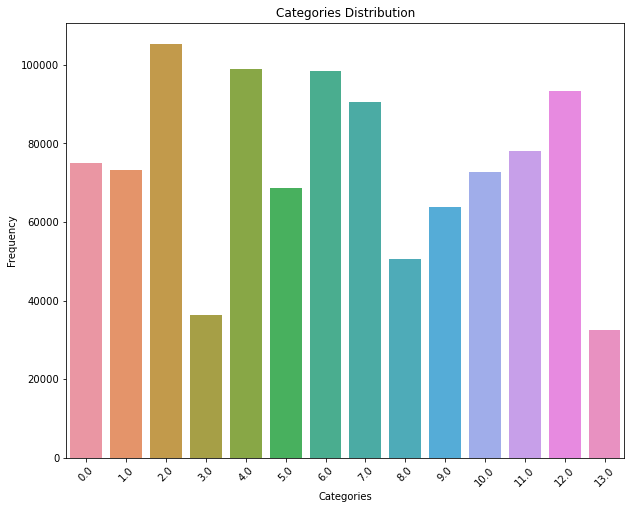

In [13]:
plt.figure(figsize=[10,8])
sns.countplot(data=df_train , x='category')
plt.xticks(rotation=45)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Categories Distribution')
plt.show()

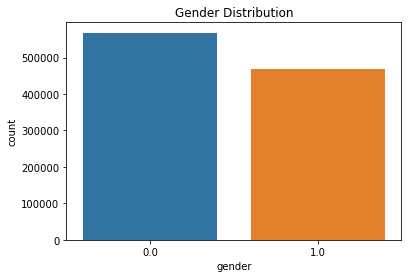

In [14]:
sns.countplot(data=df_train , x='gender')
plt.title('Gender Distribution')
plt.show()

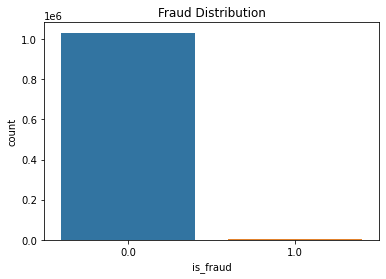

In [15]:
sns.countplot(data=df_train , x='is_fraud')
plt.title('Fraud Distribution')
plt.show()

# Step5: Classification

## Convert Pandas df to Spark df to use the spark lib to do data analysis

In [16]:
spark = SparkSession.builder.appName("PandasToSpark").getOrCreate()
df_train = spark.createDataFrame(df_train)
df_test = spark.createDataFrame(df_test)

In [17]:
df_train.show()
num_rows = df_train.count()
print(f"Number of rows in the df_train: {num_rows}")

+---------------------+--------+--------+------------------+-----+-----+------+------+-----+-----+-------+------------------+-------------------+---------+-----+-----+---------+-------------+------------------+-------------------+--------+
|trans_date_trans_time|merchant|category|               amt|first| last|gender|street| city|state|    zip|               lat|               long| city_pop|  job|  dob|trans_num|    unix_time|         merch_lat|         merch_long|is_fraud|
+---------------------+--------+--------+------------------+-----+-----+------+------+-----+-----+-------+------------------+-------------------+---------+-----+-----+---------+-------------+------------------+-------------------+--------+
|             325426.0|   340.0|    13.0| 6.510000228881836|239.0|234.0|   0.0| 677.0|270.0| 18.0|70732.0| 30.65760040283203| -91.62640380859375|   1178.0| 99.0|157.0|1234400.0|1.338993792E9|31.189016342163086| -91.42637634277344|     0.0|
|             785703.0|   476.0|     0.0

In [18]:
df_test.show()
num_rows = df_test.count()
print(f"Number of rows in the df_test: {num_rows}")

+---------------------+--------+--------+------------------+-----+-----+------+------+-----+-----+-------+------------------+-------------------+---------+-----+-----+---------+-------------+------------------+-------------------+--------+
|trans_date_trans_time|merchant|category|               amt|first| last|gender|street| city|state|    zip|               lat|               long| city_pop|  job|  dob|trans_num|    unix_time|         merch_lat|         merch_long|is_fraud|
+---------------------+--------+--------+------------------+-----+-----+------+------+-----+-----+-------+------------------+-------------------+---------+-----+-----+---------+-------------+------------------+-------------------+--------+
|            1027327.0|   629.0|     9.0|194.50999450683594|152.0|414.0|   1.0| 250.0|768.0| 38.0|15686.0|40.615299224853516| -79.45449829101562|    972.0|378.0|922.0|1296509.0|1.362841728E9| 40.42045211791992|  -78.8650131225586|     0.0|
|             538776.0|   180.0|     5.0

## Sample to 10,000 train rows to do SVM classifaction

In [19]:
# Calculate the fraction to sample based on total count of the data
fraction = 10000 / df_train.count()

# Sample the data using the calculated fraction
data_svm_sample = df_train.sample(fraction=fraction, seed=int(time.time()))

# Ensure exactly 10,000 rows (limit the result)
data_svm_sample = data_svm_sample.limit(10000)

# Show the sampled data
data_svm_sample.show()
num_rows = data_svm_sample.count()
print(f"Number of rows in the sampled data: {num_rows}")

+---------------------+--------+--------+------------------+-----+-----+------+------+-----+-----+-------+------------------+-------------------+--------+-----+-----+---------+-------------+------------------+-------------------+--------+
|trans_date_trans_time|merchant|category|               amt|first| last|gender|street| city|state|    zip|               lat|               long|city_pop|  job|  dob|trans_num|    unix_time|         merch_lat|         merch_long|is_fraud|
+---------------------+--------+--------+------------------+-----+-----+------+------+-----+-----+-------+------------------+-------------------+--------+-----+-----+---------+-------------+------------------+-------------------+--------+
|             526559.0|   446.0|     3.0| 74.38999938964844|292.0|178.0|   0.0| 603.0|811.0| 34.0|12986.0|44.231998443603516|  -74.4905014038086|  6120.0| 70.0|584.0| 990005.0|1.345261952E9|43.599830627441406| -75.24797058105469|     0.0|
|              49539.0|   500.0|    10.0| 78

## Use PCA to reduce to 2 collumns

In [64]:
# Step 1: Drop the existing 'features' column if it already exists
if 'features' in data_svm_sample.columns:
    data_svm_sample = data_svm_sample.drop('features')
if 'features' in df_test.columns:
    df_test = df_test.drop('features')

# Step 2: Assemble features into a vector (you'll need to exclude the label column 'is_fraud')
feature_columns = [col for col in data_svm_sample.columns if col != 'is_fraud']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_svm_sample = assembler.transform(data_svm_sample)
df_test = assembler.transform(df_test)

# Step 3: Standardize the features before PCA
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(data_svm_sample)
data_svm_sample_scaled = scaler_model.transform(data_svm_sample)
df_test_scaled = scaler_model.transform(df_test)

# Step 4: Use PCA to reduce the dimensionality to 2D
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(data_svm_sample_scaled)
data_svm_sample_pca = pca_model.transform(data_svm_sample_scaled)

# Apply the same PCA model to df_test
df_test_pca = pca_model.transform(df_test_scaled)

## Train the SVM, test the accuracy and plot the svm boundary

Test Accuracy = 0.9941


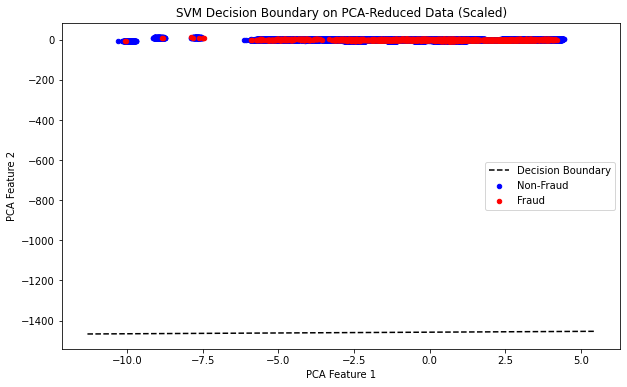

In [63]:
# Step 5: Train the SVM model using LinearSVC on the PCA-transformed training data
svm = LinearSVC(labelCol="is_fraud", featuresCol="pca_features", maxIter=10, regParam=0.1)
svm_model = svm.fit(data_svm_sample_pca)

# Step 6: Apply the trained SVM model to the test data
predictions = svm_model.transform(df_test_pca)

# Step 7: Evaluate the model accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

# Step 8: Plot the decision boundary again
import numpy as np
import matplotlib.pyplot as plt

# Extract the PCA features and labels from the training and test data
train_data = data_svm_sample_pca.select("pca_features", "is_fraud").collect()
X_train = np.array([row['pca_features'].toArray() for row in train_data])
y_train = np.array([row['is_fraud'] for row in train_data])

test_data = df_test_pca.select("pca_features", "is_fraud").collect()
X_test = np.array([row['pca_features'].toArray() for row in test_data])
y_test = np.array([row['is_fraud'] for row in test_data])

# Combine train and test sets
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Step 9: Plot the data points (fraud vs non-fraud)
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Non-Fraud', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Fraud', s=20)

# Plot the decision boundary
w = svm_model.coefficients.toArray()  # Get the coefficients
b = svm_model.intercept  # Get the intercept
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
xx = np.linspace(x_min, x_max)
yy = -(w[0] * xx + b) / w[1]
plt.plot(xx, yy, color='black', linestyle='--', label='Decision Boundary')

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('SVM Decision Boundary on PCA-Reduced Data (Scaled)')
plt.legend()
plt.show()


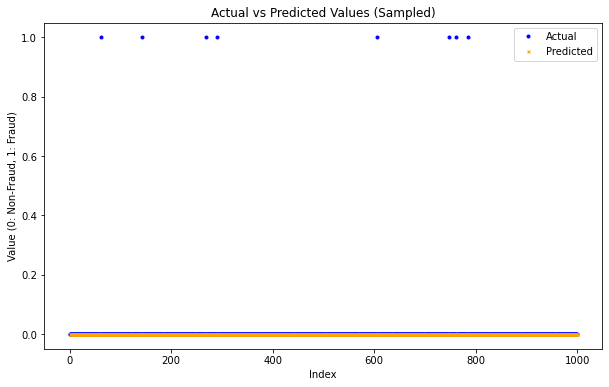

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the actual and predicted labels from the predictions DataFrame
predictions_data = predictions.select("is_fraud", "prediction").collect()

# Convert to NumPy arrays
actual = np.array([row['is_fraud'] for row in predictions_data])
predicted = np.array([row['prediction'] for row in predictions_data])

# Create an index for the x-axis
index = np.arange(len(actual))

# Plot a subset of the data for better visualization (optional)
sample_size = 1000  # You can adjust this number as needed
index_sample = index[:sample_size]
actual_sample = actual[:sample_size]
predicted_sample = predicted[:sample_size]

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))

# Plot actual values with markers
plt.plot(index_sample, actual_sample, label='Actual', color='blue', marker='o', linestyle='None', markersize=3)

# Plot predicted values with markers
plt.plot(index_sample, predicted_sample, label='Predicted', color='orange', marker='x', linestyle='None', markersize=3)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value (0: Non-Fraud, 1: Fraud)')
plt.title('Actual vs Predicted Values (Sampled)')

# Add a legend
plt.legend()

# Show the plot
plt.show()
